In [52]:
# Python
from datetime import datetime

# MPL
import matplotlib        as mpl
import matplotlib.pyplot as plt

# VPython
import vpython        as vp

# NumPy
import numpy        as np
import numpy.random as random
import numpy.linalg as linalg
from numpy import cos, exp, log, pi, sin, sqrt

# SciPy
import scipy.fft as fft
import scipy.stats as stats

import time

We will be distributing particles randomly throughout space, but mostly we will be attempting to create spherical structures to investigate approximately spherically symmetric gravitational collapse. Therefore, we will need the ability to distribute random points in space parameterized by spherical coordinates. Given the non-uniform scale factors, a simple random.rand(N) does not suffice.

In [71]:
Np = 1000   # Total number of particles in the simulation
R = 10    # Radius of the collapsing body

In [65]:
def rand_r(N,r_min=0,r_max=R):
    v_min = 1/3 * r_min**3
    v_max = 1/3 * r_max**3
    v = random.default_rng().uniform(v_min,v_max,N)
    return np.cbrt(3*v)

def rand_theta(N,theta_min=0,theta_max=pi):
    u_min = -cos(theta_min)
    u_max = -cos(theta_max)
    u = random.default_rng().uniform(u_min,u_max,N)
    return np.arccos(-u)

def rand_phi(N,phi_min=0,phi_max=2*pi):
    phi = random.default_rng().uniform(0,2*pi,N)
    return phi

In [72]:
rs = rand_r(Np)
thetas = rand_theta(Np)
phis = rand_phi(Np)

xs = rs*cos(phis)*sin(thetas)
ys = rs*sin(phis)*sin(thetas)
zs = rs*cos(thetas)

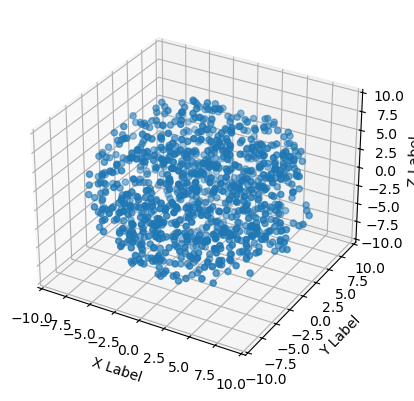

In [73]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(-10,10)

plt.show()